<a href="https://colab.research.google.com/github/samymessal/EEG_octo/blob/full_sleep_multi_label_classification/files/full_sleep_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep Spindle Study

## Building Model

In this notebook, we build a model to detect the presence of sleep spindles in the entire EEG recording.
        

In [1]:
!pip install mne -q
!pip install vmdpy -q
!pip install yasa -q
!pip install imbalanced-learn -q

In [2]:
!git clone -b full_sleep_multi_label_classification https://github.com/samymessal/EEG_octo
import sys
sys.path.append('/content/EEG_octo/files')

fatal: destination path 'EEG_octo' already exists and is not an empty directory.



## Imports

We will import the necessary libraries that are needed for processing the data, building the model, and evaluating its performance.
        

In [3]:
import imblearn
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, LayerNormalization, Lambda, concatenate
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import json
import data_preparation
import preprocess
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import Callback
import json
from tensorflow.keras.metrics import Metric
import tensorflow.keras.layers
from keras.utils import timeseries_dataset_from_array
from scipy.io import loadmat
from scipy.signal import detrend
import yasa
from scipy.signal import welch
from tensorflow.keras import Model, regularizers


DEFAULT_DIVIDER = 10000000

### Download data

Using the `processed_data` function from the previous step to download our concatenated raw with its correspondent preprocessing and features.

In [38]:
def load_eeg_data(mat_file_path):
    # Load the .mat file using scipy
    mat = loadmat(mat_file_path)
    # Extract EEG data
    return mat['EEG'][0, 0]['data']

def mk_raw_obj(eeg_data, sfreq=250):
    info = mne.create_info(
        ch_names=[f'EEG{i}' for i in range(len(eeg_data))],
        sfreq=sfreq,
        ch_types=['eeg' for _ in range(len(eeg_data))]
    )

    return mne.io.RawArray(eeg_data, info)

def load_data(file_path, labels_path):
    raw_mat = load_eeg_data(file_path)
    raw = mk_raw_obj(raw_mat)
    raw_data = raw.get_data()
    labels = pd.read_csv(labels_path)
    labels.sort_values("Timestamp", inplace=True)
    return raw, raw_data, labels

def mne_events_from_labels_df(recording_raw_obj: mne.io.Raw, labels_df: pd.DataFrame, target_label: str,):
    presence_mask = labels_df[target_label] == 1
    nb_events = len(labels_df[presence_mask])

    return np.column_stack((labels_df['Timestamp'][presence_mask], np.ones(nb_events), np.ones(nb_events)))


def preprocess_data(recording_data,
                    frequency_band,
                    sampling_freq,
                    resampling_freq,
                    labels_df,
                    target_label,
                    window_size_in_seconds):
    # Detrending
    recording_data = detrend(recording_data)

    # Create mne raw obj
    recording_raw_obj = mk_raw_obj(recording_data)
    events = mne_events_from_labels_df(recording_raw_obj, labels_df, target_label)

    # Resampling
    recording_raw_obj, events = recording_raw_obj.resample(resampling_freq, events=events)
    labels_df = pd.DataFrame(events, columns=["Timestamp", "ignore", target_label])

    # # Band pass filtering
    # bp_filter_raw_obj = recording_raw_obj.filter(frequency_band[0], frequency_band[1], verbose=0)

    return recording_raw_obj, labels_df

def hypnogram_propas(recording_raw_obj, sampling_freq=250):
    """
    Computes the propabilites of the each sleep stages at each 30s epoch.
    Then, upsamples the probabilites to match the shape of the recording.
    ### Parameters:
    recording_data: ndarray of the recording
    ### Returns:
    Tuple of shape four, each item is a 1D array of the probability of a sleep stage at a given timestamp.
    Four for the four sleep stages: awake, REM, NREM1, NREM2, NREM3
    """
    # For some reason, yasa doesn't work properly with the unscaled data.
    scalled_raw_obj = mk_raw_obj(recording_raw_obj.get_data() / DEFAULT_DIVIDER, sfreq=sampling_freq)
    sls = yasa.SleepStaging(scalled_raw_obj, eeg_name="EEG0")
    hypno_proba = sls.predict_proba()
    return [yasa.hypno_upsample_to_data(hypno_proba[column], 1/30, scalled_raw_obj, verbose=False) for column in hypno_proba.columns]

def window_data(data, window_size):
    num_windows = len(data) - window_size + 1
    return np.array([data[i:i+window_size] for i in range(num_windows)]), num_windows


def dataset_from_files(
        recording_files,
        labels_files,
        target_label,
        resampling_freq,
        sampling_freq,
        frequency_band,
        window_size_in_seconds,
        shuffle=False,
        batch_size=128
        ):
    time_series = []
    target_timeseries = []
    window_size = int(window_size_in_seconds * resampling_freq)
    for recording_file, labels_file in zip(recording_files, labels_files):
        # Loading
        labels_df = pd.read_csv(labels_file)
        recording_data = load_eeg_data(recording_file)

        # Preprocessing
        preprocessed_recording_raw_obj, labels_df = preprocess_data(
            recording_data,
            frequency_band,
            sampling_freq,
            resampling_freq,
            labels_df,
            target_label,
            window_size_in_seconds,
            )

        # Feature engineering
        hypno_propas = hypnogram_propas(preprocessed_recording_raw_obj, sampling_freq=sampling_freq)

        # Features formatting
        time_serie = np.column_stack((preprocessed_recording_raw_obj.get_data().squeeze(), *hypno_propas))
        target_timeserie = np.zeros(time_serie.shape[0])
        for timestamp in labels_df["Timestamp"]:
          target_timeserie[int(timestamp)] = 1
        windowed_time_serie, num_windows = window_data(time_serie, window_size)
        target_timeserie = target_timeserie[:windowed_time_serie.shape[0]]

        # Resampling
        OVER_REP_SAMPLES_RATIO = 0.5
        OVER_REP_SAMPLES = int(OVER_REP_SAMPLES_RATIO * windowed_time_serie.shape[0])
        UNDER_REP_SAMPLES_RATIO = 0.3
        UNDER_REP_SAMPLES = 5000 #int(OVER_REP_SAMPLES * UNDER_REP_SAMPLES_RATIO)
        def resample(nb_desired_samples, resampling_target, data, targets):
            print("Counts before undersampling:", np.unique(targets, return_counts=True))
            resample_mask = targets == resampling_target
            dont_resample_mask = targets != resampling_target
            resample_data = data[resample_mask]
            resample_targets = targets[resample_mask]
            dont_resample_data = data[dont_resample_mask]
            dont_resample_targets = targets[dont_resample_mask]
            # Downsample
            resampled_indices = np.random.choice(resample_data.shape[0], nb_desired_samples, replace=resample_data.shape[0] < nb_desired_samples)
            resampled_data = resample_data[resampled_indices]
            resampled_targets = resample_targets[resampled_indices]
            # Combine
            data = np.concatenate([resampled_data, dont_resample_data])
            targets = np.concatenate([resampled_targets, dont_resample_targets])
            print("Counts after undersampling:", np.unique(targets, return_counts=True))
            return data, targets

        windowed_time_serie, target_timeserie = resample(OVER_REP_SAMPLES, 0, windowed_time_serie, target_timeserie)
        windowed_time_serie, target_timeserie = resample(UNDER_REP_SAMPLES, 1, windowed_time_serie, target_timeserie)

        time_series.append(windowed_time_serie)
        target_timeseries.append(target_timeserie)

    concat_timeseries = np.concatenate(time_series, axis=0)
    concat_target_timeseries = np.concatenate(target_timeseries, axis=0)
    print("concat_timeseries:", concat_timeseries.shape)
    print("concat_target_timeseries:", concat_target_timeseries.shape)


    class_weights = compute_class_weight("balanced", classes=np.unique(concat_target_timeseries), y=concat_target_timeseries.ravel())
    dataset = tf.data.Dataset.from_tensor_slices((concat_timeseries, concat_target_timeseries))
    dataset = dataset.batch(batch_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(concat_timeseries))

    return dataset, window_size, class_weights


dataset, window_size, class_weights = dataset_from_files(
    ["/content/EEG_octo/dataset/train_S002_night1_hackathon_raw.mat",
    "/content/EEG_octo/dataset/train_S003_night5_hackathon_raw.mat"
    ],
    ["/content/EEG_octo/dataset/train_S002_labeled.csv",
    "/content/EEG_octo/dataset/train_S003_labeled.csv"
    ],
    sampling_freq=250,
    resampling_freq=20,
    target_label="SS1",
    frequency_band=(8, 16),
    window_size_in_seconds=2.5,
    shuffle=True
)

Creating RawArray with float64 data, n_channels=1, n_times=4965399
    Range : 0 ... 4965398 =      0.000 ... 19861.592 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=397232
    Range : 0 ... 397231 =      0.000 ...  1588.924 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Counts before undersampling: (array([0., 1.]), array([396491,    692]))
Counts after undersampling: (array([0., 1.]), array([198591,    692]))
Counts before undersampling: (array([0., 1.]), array([198591,    692]))
Counts after undersampling: (array([0., 1.]), array([198591,   5000]))
Creating RawArray with float64 data, n_channels=1, n_times=5772730
    Range : 0 ... 5772729 =      0.000 ... 23090.916 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=461818
    Range : 0 ... 461817 =      0.000 ...  1847.268 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Counts before undersampling: (array([0., 1.]), array([461428,    341]))
Counts after undersampling: (array([0., 1.]), array([230884,    341]))
Counts before undersampling: (array([0., 1.]), array([230884,    341]))
Counts after undersampling: (array([0., 1.]), array([230884,   5000]))
concat_timeseries: (439475, 50, 6)
concat_target_timeseries: (439475,)



#### Model

The chosen model is an LSTM, since we are dealing with timeframes, LSTM are known to deal well with time depending samples. A k-cross validation is implemented, partitioning the data into 5 parts and alterning between the 4 parts for training and the 1 for testing.
        

In [11]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        p = self.precision.result()
        r = self.recall.result()
        self.f1_score.assign(2 * ((p * r) / (p + r + tf.keras.backend.epsilon())))

    def result(self):
        return self.f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0)

In [12]:
def create_model():
    input_layer = keras.Input(shape=(window_size, 6))

    # Input layer for the EEG time series
    input_eeg = Lambda(lambda y: y[:, :, 0:2])(input_layer)

    # Layer normalization for EEG
    norm_eeg = LayerNormalization()(input_eeg)

    x = Conv1D(
        filters=32, kernel_size=3, strides=1, activation="relu", padding="same"
    )(norm_eeg)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(
        filters=64, kernel_size=3, strides=1, activation="relu", padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(
        filters=128, kernel_size=5, strides=1, activation="relu", padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Now you can flatten the output if you haven't applied global pooling before
    x = Flatten()(x)

    # Input layer for the other features
    first_elements = Lambda(lambda y: y[:, 0, 2:])(input_layer)
    # Concatenate the CNN output and the first elements of the other features
    concatenated = concatenate([x, first_elements])

    x = Dense(
        2048, activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(concatenated)
    x = Dropout(0.2)(x)

    x = Dense(
        1024,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(x)
    x = Dropout(0.2)(x)
    x = Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
    )(x)
    output_layer = Dense(1, activation="sigmoid")(x)

    return Model(inputs=input_layer, outputs=output_layer)


Epoch 1/30
3434/3434 [==============================] - 68s 18ms/step - loss: 0.7197 - accuracy: 0.9770 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2/30
3434/3434 [==============================] - 61s 17ms/step - loss: 0.7086 - accuracy: 0.9772 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 3/30
3434/3434 [==============================] - 61s 17ms/step - loss: 0.4064 - accuracy: 0.9772 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 4/30
3434/3434 [==============================] - 61s 17ms/step - loss: 0.2712 - accuracy: 0.9772 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 5/30
3434/3434 [==============================] - 61s 17ms/step - loss: 0.2840 - accuracy: 0.9772 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 6/30
3434/3434 [==============================] - 61s 18ms/step - loss: 0.2974 - accuracy: 0.9772 - prec

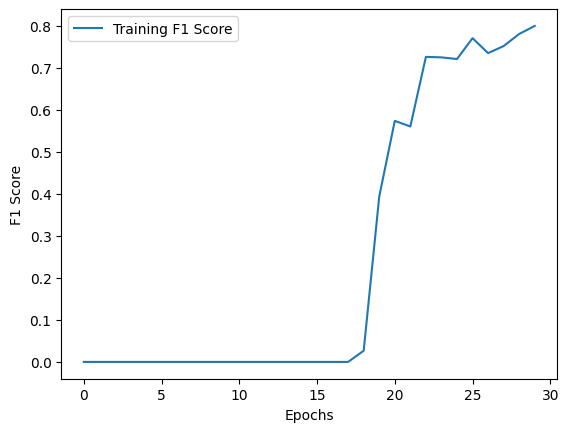

In [39]:
# Define the model architecture
model = create_model()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        F1Score(),
    ]
)

# Train the model
history = model.fit(
    dataset,
    epochs=30,
    class_weight={label: 1 for label, weight in enumerate(class_weights)}
)


training_f1_scores = history.history['f1_score']
# validation_f1_scores = history.history['val_f1_score']

plt.plot(training_f1_scores, label='Training F1 Score')
# plt.plot(validation_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()